# **Image segmentation using FCN-8 decoder**

An example of image segmentation of hand written digits using m2nist dataset and Fully Convolutional Network (FCN-8).

Original paper: [Fully Convolutional Networks for Semantic Segmentation](https://arxiv.org/pdf/1411.4038.pdf), *Jonathan Long, Evan Shelhamer, Trevor Darrell, 2015*

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import PIL
import os
import zipfile

## 1. Dataset

### 1.1 Download and unpack the dataset

In [2]:
!wget --no-check-certificate https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/m2nist.zip -O /tmp/m2nist.zip

--2023-05-22 23:20:33--  https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/m2nist.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.163.128, 142.251.167.128, 172.253.62.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.163.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17378168 (17M) [application/zip]
Saving to: ‘/tmp/m2nist.zip’

/tmp/m2nist.zip     100%[===================>]  16.57M  57.6MB/s    in 0.3s    

2023-05-22 23:20:33 (57.6 MB/s) - ‘/tmp/m2nist.zip’ saved [17378168/17378168]



In [3]:
ZIP_DIR = '/tmp/m2nist.zip'
DATASET_DIR = '/dataset'

with zipfile.ZipFile(ZIP_DIR, 'r') as unpack:
    unpack.extractall(DATASET_DIR)

### 1.2 Load dataset functions
Dataset is stored as two Numpy files for images and segmentation masks.
- **Images** 64x84 images with multiple digits.
- **Segmentation** 64x84x11 images with separate segmentation masks for 0-9 digits and background. 

**There are 5000 records total.** We split them into train, test and validation datasets.

*Important: re-running this cell might cause colab to crash due to lack of memory.*

In [4]:
def preprocess_dataset(image, mask):
    mask = tf.cast(mask, dtype='int32')

    image = tf.cast(image, dtype='float32')
    image /= 255
    image = tf.expand_dims(image, axis=-1)

    return image, mask


def create_datasets(images_dir, segmentation_dir):

    images = np.load(images_dir)
    segmentation = np.load(segmentation_dir)

    print(f"Images shape: {images.shape}\nSegmentation shape: {segmentation.shape}")

    train_img, val_img, train_seg, val_seg = train_test_split(images, segmentation, test_size=0.2, shuffle=True)
    val_img, test_img, val_seg, test_seg = train_test_split(val_img, val_seg, test_size=0.2, shuffle=True)

    print(f'\nDatasets size:\nTrain: {train_img.shape[0]}\tTest: {test_img.shape[0]}\tVal: {val_img.shape[0]}')

    train_dataset = tf.data.Dataset.from_tensor_slices((train_img, train_seg))
    train_dataset = train_dataset.shuffle(512, reshuffle_each_iteration=True).batch(BATCH_SIZE)
    train_dataset = train_dataset.map(preprocess_dataset)

    test_dataset = tf.data.Dataset.from_tensor_slices((test_img, test_seg))
    test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)
    test_dataset = test_dataset.map(preprocess_dataset)

    val_dataset = tf.data.Dataset.from_tensor_slices((val_img, val_seg))
    val_dataset = val_dataset.batch(BATCH_SIZE)
    val_dataset = val_dataset.map(preprocess_dataset)

    return train_dataset, test_dataset, val_dataset

### 1.3 Create the train, test and validation datasets

In [5]:
IMAGES_DIR = f'{DATASET_DIR}/combined.npy'
SEGMENTATION_DIR = f'{DATASET_DIR}/segmented.npy'
CLASSES_AMOUNT = 11
BATCH_SIZE = 32

print(f"Loading dataset...\nNumber of classes: {CLASSES_AMOUNT}\n")

train_dataset, test_dataset, val_dataset = create_datasets(IMAGES_DIR, SEGMENTATION_DIR)

Loading dataset...
Number of classes: 11

Images shape: (5000, 64, 84)
Segmentation shape: (5000, 64, 84, 11)

Datasets size:
Train: 4000	Test: 200	Val: 800


### 1.4 Preview sample images

In [6]:
def convert_mask_to_image(mask):

    seg_img = np.zeros( (mask.shape[0],mask.shape[1], 3) ).astype('float')

    for c in range(CLASSES_AMOUNT):
        segc = (mask == c)
        seg_img[:,:,0] += segc*( colors[c][0] * 255.0)
        seg_img[:,:,1] += segc*( colors[c][1] * 255.0)
        seg_img[:,:,2] += segc*( colors[c][2] * 255.0)

    return seg_img.astype('uint8')


def preview_dataset(dataset, amount):

    cols = 4
    rows = 2

    fig, axs = plt.subplots(nrows=rows * 2, ncols=cols, figsize=(10, 8))

    for i, data in enumerate(dataset.take(amount)):
        image, mask = data
        merged_mask = np.argmax(mask, axis=3)
        merged_mask = convert_mask_to_image(merged_mask[0])

        img_index = i * 2
        seg_index = img_index + 1

        axs[img_index // cols, img_index % cols].imshow(image[0], cmap='gray')
        axs[img_index // cols, img_index % cols].axis('off')

        axs[seg_index // cols, seg_index % cols].imshow(merged_mask)
        axs[seg_index // cols, seg_index % cols].axis('off')

    fig.tight_layout()
    fig.show()

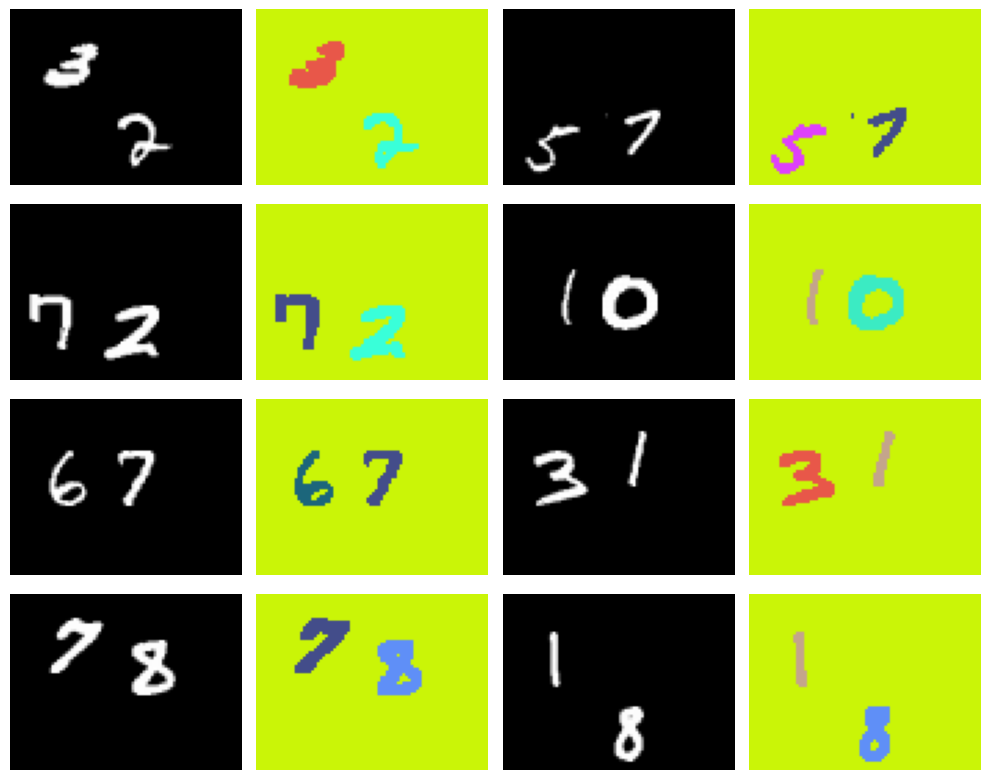

In [7]:
colors = [tuple(np.random.randint(256, size=3) / 255.0) for i in range(CLASSES_AMOUNT)]

preview_dataset(train_dataset, amount=8)

## 2. FCN

### 2.1 Downsampling path

**Convolutional block**

It is suggested to initialize weight with He or Xavier initialization when using leaky relu.

In [8]:
IMAGE_ORDERING = 'channels_last'

def conv_block(input, filters, kernel_size, pooling_size, pool_strides, index):
    x = tf.keras.layers.Conv2D(filters, 
                               kernel_size, 
                               padding='same', 
                               kernel_initializer='he_normal',
                               data_format=IMAGE_ORDERING)(input)

    x = tf.keras.layers.LeakyReLU()(x)
    
    x = tf.keras.layers.Conv2D(filters, 
                               kernel_size, 
                               padding='same',
                               kernel_initializer='he_normal',
                               data_format=IMAGE_ORDERING)(x)
    
    x = tf.keras.layers.LeakyReLU()(x)
    
    x = tf.keras.layers.MaxPooling2D(pooling_size)(x)
    x = tf.keras.layers.BatchNormalization(name=f"END_OF_CONVBLOCK_{index}")(x)

    return x

In [9]:
def FCN8(input_height=64, input_width=84):
    img_input = tf.keras.layers.Input(shape=(input_height,input_width, 1))

    x = tf.keras.layers.ZeroPadding2D(((0, 0), (0, 96-input_width)))(img_input)

    x = conv_block(x, filters=32,   kernel_size=3,  pooling_size=2, pool_strides=2, index=1)
    x = conv_block(x, filters=64,   kernel_size=3,  pooling_size=2, pool_strides=2, index=2)
    x = conv_block(x, filters=128,  kernel_size=3,  pooling_size=2, pool_strides=2, index=3)
    f3 = x

    x = conv_block(x, filters=256,  kernel_size=3,  pooling_size=2, pool_strides=2, index=4)
    f4 = x

    x = conv_block(x, filters=256,  kernel_size=3,  pooling_size=2, pool_strides=2, index=5)
    f5 = x
  
    return (f3, f4, f5), img_input

### 2.2 Upsampling path

In [10]:
def FCN8_decoder(convs, n_classes):
    f3, f4, f5 = convs
    n = 512

    x = tf.keras.layers.Conv2D(filters=n, 
                               kernel_size=(7,7), 
                               activation='relu', 
                               padding='same', 
                               name="conv6", 
                               data_format=IMAGE_ORDERING)(f5)

    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Conv2D(filters=n, 
                               kernel_size=(1, 1),
                               activation='relu',
                               padding='same', 
                               name="conv7", 
                               data_format=IMAGE_ORDERING)(x)

    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Conv2D(filters=n_classes,  
                               kernel_size=(1, 1), 
                               activation='relu', 
                               padding='same', 
                               data_format=IMAGE_ORDERING)(x)

    x = tf.keras.layers.Conv2DTranspose(filters=n_classes, 
                                        kernel_size=(4,4),  
                                        strides=(2,2), 
                                        data_format=IMAGE_ORDERING,
                                        use_bias=False)(f5)

    x = tf.keras.layers.Cropping2D(cropping=(1,1))(x)

    x2 = f4
    x2 = tf.keras.layers.Conv2D(filters=n_classes, 
                                kernel_size=(1, 1), 
                                activation='relu', 
                                padding='same',
                                data_format=IMAGE_ORDERING)(x2)

    x = tf.keras.layers.Add()([x, x2])

    x = tf.keras.layers.Conv2DTranspose(filters=n_classes, 
                                        kernel_size=(4,4),  
                                        strides=(2,2), 
                                        data_format=IMAGE_ORDERING,
                                        use_bias=False)(x)

    x = tf.keras.layers.Cropping2D(cropping=(1, 1))(x)

    x2 = f3
    x2 = tf.keras.layers.Conv2D(filters=n_classes,
                                kernel_size=(1, 1), 
                                activation='relu', 
                                padding='same', 
                                data_format=IMAGE_ORDERING)(x2)

    x = tf.keras.layers.Add()([x, x2])

    x = tf.keras.layers.Conv2DTranspose(filters=n_classes, 
                                        kernel_size=(8,8),  
                                        strides=(8,8), 
                                        data_format=IMAGE_ORDERING,
                                        use_bias=False)(x)

    x = tf.keras.layers.Cropping2D(((0, 0), (0, 96-84)))(x)

    y = (tf.keras.layers.Activation('sigmoid'))(x)

    return y


### 2.3 Complete model

In [11]:
convs, img_input = FCN8()

decoder = FCN8_decoder(convs, CLASSES_AMOUNT)

model = tf.keras.Model(inputs=img_input, outputs=decoder)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 84, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 64, 96, 1)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 96, 32)   320         ['zero_padding2d[0][0]']         
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64, 96, 32)   0           ['conv2d[0][0]']                 
                                                                                              

## 3. Train model
Using `OneHotIoU` metric (intersection over union) we can see how our model perform in segmentation task comparing the true mask and predictions. We could see IoU per digit but for that we have to set a separate metric per tested class therefore it will significantly impact performance. If you wish you can remove this as **we will do the IoU per class in evaluation section.** It will improve speed of training.


### $$IoU = \frac {area\ of\ overlap}{area\ of\ union}$$

### 3.1 Compile the model

In [12]:
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy', tf.keras.metrics.OneHotIoU(num_classes=CLASSES_AMOUNT, target_class_ids=np.arange(CLASSES_AMOUNT))]
)

### 3.2 Train the model
20 epochs are considered enough but you can train for 50 to get better results.

*Early stopping on `OneHotIoU` is not fully implemented into Tensorflow so we can`t use it without writing a workaround with custom callback.*

In [13]:
EPOCHS = 40

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint('model/checkpoint/',
                                                      monitor='val_loss',
                                                      save_best_only=True,
                                                      initial_value_threshold=0.03)

history = model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset, callbacks=[early_stopping, model_checkpoint])

Epoch 1/40
125/125 [==============================] - 25s 52ms/step - loss: 0.5507 - accuracy: 0.8509 - one_hot_io_u: 0.0818 - val_loss: 0.2467 - val_accuracy: 0.9418 - val_one_hot_io_u: 0.0872
Epoch 2/40
125/125 [==============================] - 5s 40ms/step - loss: 0.2168 - accuracy: 0.9426 - one_hot_io_u: 0.0869 - val_loss: 0.2255 - val_accuracy: 0.9420 - val_one_hot_io_u: 0.0856
Epoch 3/40
125/125 [==============================] - 6s 46ms/step - loss: 0.1958 - accuracy: 0.9430 - one_hot_io_u: 0.1052 - val_loss: 0.1988 - val_accuracy: 0.9423 - val_one_hot_io_u: 0.0921
Epoch 4/40
125/125 [==============================] - 6s 45ms/step - loss: 0.1634 - accuracy: 0.9487 - one_hot_io_u: 0.2106 - val_loss: 0.1446 - val_accuracy: 0.9526 - val_one_hot_io_u: 0.3168
Epoch 5/40
125/125 [==============================] - 7s 57ms/step - loss: 0.1052 - accuracy: 0.9628 - one_hot_io_u: 0.4540 - val_loss: 0.0896 - val_accuracy: 0.9677 - val_one_hot_io_u: 0.5654
Epoch 6/40
125/125 [==============

125/125 [==============================] - 10s 83ms/step - loss: 0.0226 - accuracy: 0.9910 - one_hot_io_u: 0.8671 - val_loss: 0.0285 - val_accuracy: 0.9889 - val_one_hot_io_u: 0.8290
Epoch 26/40
125/125 [==============================] - 6s 51ms/step - loss: 0.0214 - accuracy: 0.9914 - one_hot_io_u: 0.8744 - val_loss: 0.0307 - val_accuracy: 0.9883 - val_one_hot_io_u: 0.8169
Epoch 27/40
125/125 [==============================] - ETA: 0s - loss: 0.0210 - accuracy: 0.9916 - one_hot_io_u: 0.8765

125/125 [==============================] - 10s 82ms/step - loss: 0.0210 - accuracy: 0.9916 - one_hot_io_u: 0.8765 - val_loss: 0.0285 - val_accuracy: 0.9889 - val_one_hot_io_u: 0.8268
Epoch 28/40
125/125 [==============================] - 5s 41ms/step - loss: 0.0210 - accuracy: 0.9916 - one_hot_io_u: 0.8767 - val_loss: 0.0296 - val_accuracy: 0.9890 - val_one_hot_io_u: 0.8274
Epoch 29/40
125/125 [==============================] - 6s 47ms/step - loss: 0.0269 - accuracy: 0.9897 - one_hot_io_u: 0.8402 - val_loss: 0.0607 - val_accuracy: 0.9827 - val_one_hot_io_u: 0.7394
Epoch 30/40
125/125 [==============================] - 5s 41ms/step - loss: 0.0239 - accuracy: 0.9906 - one_hot_io_u: 0.8582 - val_loss: 0.0290 - val_accuracy: 0.9890 - val_one_hot_io_u: 0.8307
Epoch 31/40
124/125 [============================>.] - ETA: 0s - loss: 0.0203 - accuracy: 0.9919 - one_hot_io_u: 0.8805

125/125 [==============================] - 11s 85ms/step - loss: 0.0203 - accuracy: 0.9919 - one_hot_io_u: 0.8805 - val_loss: 0.0272 - val_accuracy: 0.9897 - val_one_hot_io_u: 0.8405
Epoch 32/40
125/125 [==============================] - 5s 42ms/step - loss: 0.0198 - accuracy: 0.9921 - one_hot_io_u: 0.8833 - val_loss: 0.0277 - val_accuracy: 0.9896 - val_one_hot_io_u: 0.8355
Epoch 33/40
125/125 [==============================] - 5s 41ms/step - loss: 0.0189 - accuracy: 0.9925 - one_hot_io_u: 0.8888 - val_loss: 0.0276 - val_accuracy: 0.9893 - val_one_hot_io_u: 0.8324
Epoch 34/40
125/125 [==============================] - ETA: 0s - loss: 0.0185 - accuracy: 0.9926 - one_hot_io_u: 0.8911

125/125 [==============================] - 11s 85ms/step - loss: 0.0185 - accuracy: 0.9926 - one_hot_io_u: 0.8911 - val_loss: 0.0255 - val_accuracy: 0.9902 - val_one_hot_io_u: 0.8464
Epoch 35/40
125/125 [==============================] - 6s 47ms/step - loss: 0.0183 - accuracy: 0.9927 - one_hot_io_u: 0.8922 - val_loss: 0.0266 - val_accuracy: 0.9898 - val_one_hot_io_u: 0.8404
Epoch 36/40
125/125 [==============================] - 5s 42ms/step - loss: 0.0179 - accuracy: 0.9929 - one_hot_io_u: 0.8944 - val_loss: 0.0273 - val_accuracy: 0.9898 - val_one_hot_io_u: 0.8388
Epoch 37/40
125/125 [==============================] - 6s 47ms/step - loss: 0.0175 - accuracy: 0.9930 - one_hot_io_u: 0.8966 - val_loss: 0.0274 - val_accuracy: 0.9896 - val_one_hot_io_u: 0.8357
Epoch 38/40
125/125 [==============================] - 5s 44ms/step - loss: 0.0174 - accuracy: 0.9931 - one_hot_io_u: 0.8973 - val_loss: 0.0308 - val_accuracy: 0.9889 - val_one_hot_io_u: 0.8193
Epoch 39/40
125/125 [====================

125/125 [==============================] - 11s 89ms/step - loss: 0.0171 - accuracy: 0.9932 - one_hot_io_u: 0.8986 - val_loss: 0.0249 - val_accuracy: 0.9907 - val_one_hot_io_u: 0.8519


### 3.3 Display accuracy and loss plot
`OneHotIoU` is not fully implemented by Tensorflow so we can't get it from history.

*Todo: create a workaround to have a full chart of IoU changes per epoch per digit*

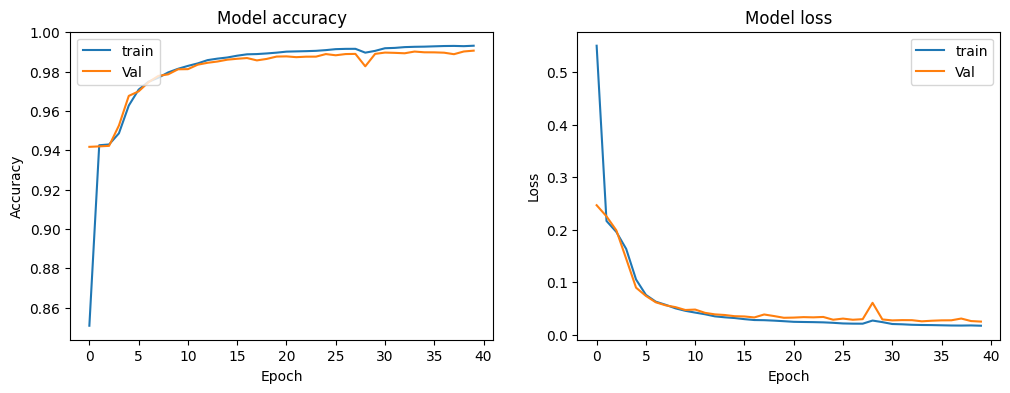

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))

axs[0].set_title("Model accuracy")
axs[0].plot(history.history["accuracy"])
axs[0].plot(history.history["val_accuracy"])
axs[0].legend(["train", "Val"], loc="upper left")
axs[0].set_ylabel("Accuracy")
axs[0].set_xlabel("Epoch")

axs[1].set_title("Model loss")
axs[1].plot(history.history["loss"])
axs[1].plot(history.history["val_loss"])
axs[1].legend(["train", "Val"], loc="upper right")
axs[1].set_ylabel("Loss")
axs[1].set_xlabel("Epoch")

fig.show()

## 4. Evaluation

### 4.1 Intersection over Union (IoU)
We are computing IoU per each digit, to do this we are doing a trick to add a metric for each digit and evaluate the model on test dataset.

IoU gives additional information about the performance of our model. You can clearly see that accuracy of 98% doesn't mean the segmentations overlap in 98%.

In [15]:
iou_metrics = [tf.keras.metrics.OneHotIoU(num_classes=CLASSES_AMOUNT, target_class_ids=[i], name=f"Digit {i}") for i in range(CLASSES_AMOUNT)]

model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'] + iou_metrics
)

metrics_eval = model.evaluate(test_dataset)

print(f"\nLoss: {metrics_eval[0]:.4f}\nAccuracy: {metrics_eval[1]:.4f}\n")

for i in range(2,12):
    print(f'Digit {i-2}: {metrics_eval[i]:.4f}')

print(f"\nBackground: {metrics_eval[12]:.4f}")

6/6 [==============================] - 4s 45ms/step - loss: 0.0256 - accuracy: 0.9908 - Digit 0: 0.8883 - Digit 1: 0.8570 - Digit 2: 0.8605 - Digit 3: 0.8329 - Digit 4: 0.8006 - Digit 5: 0.7986 - Digit 6: 0.8652 - Digit 7: 0.8755 - Digit 8: 0.8370 - Digit 9: 0.7650 - Digit 10: 0.9910

Loss: 0.0256
Accuracy: 0.9908

Digit 0: 0.8883
Digit 1: 0.8570
Digit 2: 0.8605
Digit 3: 0.8329
Digit 4: 0.8006
Digit 5: 0.7986
Digit 6: 0.8652
Digit 7: 0.8755
Digit 8: 0.8370
Digit 9: 0.7650

Background: 0.9910


### 4.4 F1 score

F1 score is another metric which tells how well our model performs. It consists of Precision and Recall
* Precision: measures the accuracy of positive predictions.
* Recall: measures the abillity to identify true positives.

$$Precision = \frac{TP}{TP+FP}~~~~~~ Recall = \frac{TP}{TP+FN}$$

The final equation:

### $$F1 = 2\frac {Precision * Recall}{Precision + Recall}$$

*Todo: add dice score?*

**Get the results**

Furthermore we are doing argmax on them to have a single mask rather than masks per class.

In [16]:
results = model.predict(test_dataset)
print(results.shape)

results = np.argmax(results, axis=3)
print(results.shape)

6/6 [==============================] - 0s 12ms/step
(192, 64, 84, 11)
(192, 64, 84)


**F1 score helper functions**

In [17]:
def get_f1_score(y_true, y_pred, average='binary'):

    unknown_mask = np.logical_or(y_true == -1, y_pred == -1)
    f1 = f1_score(y_true[~unknown_mask], y_pred[~unknown_mask], average=average, zero_division=0)

    return f1


def get_f1_score_per_class(y_true, y_pred, n_classes):

    f1_list = []

    for i in range(n_classes):
        y_true_single_class = (y_true == i)
        y_pred_single_class = (y_pred == i)

        f1 = get_f1_score(y_true_single_class, y_pred_single_class)
        f1_list.append(f1)

    return f1_list

**Calculate the F1 score per digit**

We can see how f1 score performs for each class.

In [18]:
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_true = np.argmax(y_true, axis=3)

f1_per_class = get_f1_score_per_class(y_true, results, CLASSES_AMOUNT-1)
f1_total = get_f1_score(y_true, results, average='macro')

print("f1 score per digit:")

for i in range(CLASSES_AMOUNT-1):
    print(f'Digit {i}\t f1 score: {f1_per_class[i]:.4f}')

print(f'\nTotal f1 score: {f1_total:.4f}')

f1 score per digit:
Digit 0	 f1 score: 0.9408
Digit 1	 f1 score: 0.9230
Digit 2	 f1 score: 0.9250
Digit 3	 f1 score: 0.9088
Digit 4	 f1 score: 0.8894
Digit 5	 f1 score: 0.8879
Digit 6	 f1 score: 0.9277
Digit 7	 f1 score: 0.9334
Digit 8	 f1 score: 0.9113
Digit 9	 f1 score: 0.8670

Total f1 score: 0.9191


### 4.3 Visualize predictions

In [19]:
def visualize_prediction(image, y_true, y_pred):
    fig, axs = plt.subplots(1,3, figsize=(9,3))
    axs[0].imshow(image)
    axs[0].axis('off')
    axs[1].imshow(y_true)
    axs[1].axis('off')
    axs[2].imshow(y_pred)
    axs[2].axis('off')
    fig.show()

1/1 [==============================] - 1s 587ms/step
Digit 6 F1 score: 0.9441
Digit 9 F1 score: 0.8105


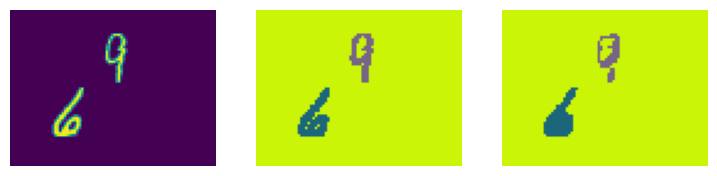

1/1 [==============================] - 0s 22ms/step
Digit 3 F1 score: 0.0659
Digit 6 F1 score: 0.9635


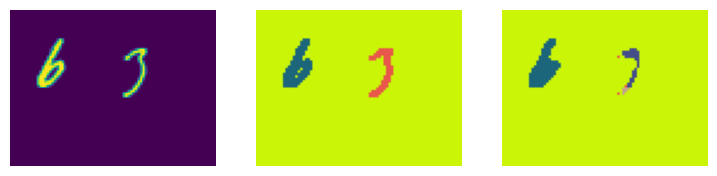

1/1 [==============================] - 0s 22ms/step
Digit 0 F1 score: 0.8954
Digit 6 F1 score: 0.9689


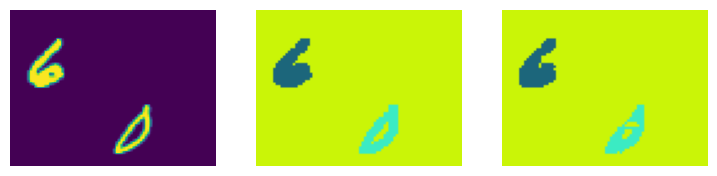

1/1 [==============================] - 0s 23ms/step
Digit 3 F1 score: 0.8718
Digit 9 F1 score: 0.9187


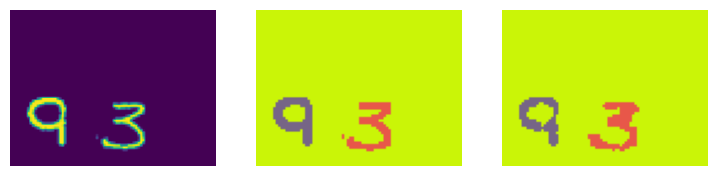

1/1 [==============================] - 0s 25ms/step
Digit 3 F1 score: 0.8291
Digit 5 F1 score: 0.9679


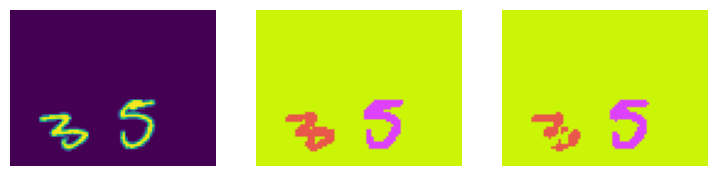

In [20]:
unbatched_test = test_dataset.unbatch()

samples_amount = 10

for img, mask in unbatched_test.take(5):

    pred_img = np.expand_dims(img, axis=0)
    pred = model.predict(pred_img)

    mask = np.argmax(mask, axis=2)
    pred = np.argmax(pred, axis=3)

    f1_per_class = get_f1_score_per_class(mask, np.squeeze(pred), CLASSES_AMOUNT-1)

    mask = np.squeeze(mask)
    pred = np.squeeze(pred)

    for i in range(CLASSES_AMOUNT-1):
        if f1_per_class[i] != 0:
           print(f'Digit {i} F1 score: {f1_per_class[i]:.4f}')

            
    visualize_prediction(img, convert_mask_to_image(mask), convert_mask_to_image(pred))
    plt.pause(0.1)